In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils

In [2]:
#open and combine all data
base_key = 'BTCUSD'
other_keys =('ETHUSD', 'SOLUSD') #, 'DOTUSD', 'ADAUSD', 'ALGOUSD')
full_df = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', base_key+'.csv'))
full_df['dtime'] = pd.to_datetime(full_df['dtime'], format='%Y-%m-%d %H:%M:%S')
full_df.set_index('dtime', inplace = True)
full_df.drop(columns=['time'], inplace=True)
full_df = full_df.add_prefix(base_key+'_')

for key in other_keys:
    price_data = pd.read_csv(os.path.join('..', 'data', 'scraped_OHLC_7-13-2023', key+'.csv'))
    price_data['dtime'] = pd.to_datetime(price_data['dtime'], format='%Y-%m-%d %H:%M:%S')
    price_data.set_index('dtime', inplace = True)
    price_data.drop(columns=['time'], inplace=True)
    price_data = price_data.add_prefix(key+'_')
    full_df = pd.merge_asof(full_df, price_data, left_index=True, right_index=True, direction='nearest')

# full_df.dropna(inplace=True, axis=0, how='all')
sample_interval = 5 #in minutes
full_df = utils.ohlc_resampler(full_df, freq=f'{sample_interval}T', round = True, fill='ffill')

#normalize 'vwap', 'volume', 'count' data
norm_df = full_df.copy()
for key in full_df.keys():
    if key.endswith(('vwap', 'volume', 'count')):
        norm_df[key] = (full_df[key] - full_df[key].mean()) / full_df[key].std()

In [3]:
norm_df

,BTCUSD_open,BTCUSD_high,BTCUSD_low,BTCUSD_close,BTCUSD_volume,ETHUSD_open,ETHUSD_high,ETHUSD_low,ETHUSD_close,ETHUSD_volume,SOLUSD_open,SOLUSD_high,SOLUSD_low,SOLUSD_close,SOLUSD_volume
2022-04-13 17:35:00,41000.0,41001.6,40908.4,40908.4,-0.313087,3075.37,3075.40,3069.94,3070.00,0.618810,104.15,104.32,103.72,104.01,-0.118627
2022-04-13 17:40:00,40909.3,40920.3,40908.7,40910.0,-0.338595,3070.00,3070.00,3069.30,3070.00,-0.142503,103.90,103.96,103.90,103.96,-0.302525
2022-04-13 17:45:00,40909.9,41080.8,40879.3,40989.2,0.364001,3070.00,3078.00,3069.27,3074.20,2.103828,103.94,104.33,103.88,104.10,-0.261396
2022-04-13 17:50:00,40988.8,41020.2,40988.7,41012.0,-0.123387,3075.21,3077.68,3074.64,3076.92,-0.276298,104.07,104.40,104.05,104.30,-0.276889
2022-04-13 17:55:00,41012.0,41028.5,40983.1,41028.5,-0.318145,3076.68,3078.00,3076.56,3078.00,-0.111971,104.22,104.22,103.76,104.08,-0.267552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-13 16:15:00,30885.7,30938.2,30885.6,30920.6,0.445242,1946.33,1955.48,1946.00,1951.91,3.399791,24.49,24.63,24.38,24.38,2.315189
2023-07-13 16:20:00,30920.6,30931.0,30860.8,30910.1,0.323533,1950.01,1958.17,1945.99,1958.17,3.607296,24.38,24.50,24.35,24.50,1.087853
2023-07-13 16:25:00,30910.1,30987.6,30900.0,30900.0,4.334433,1955.74,1965.39,1955.26,1955.74,2.135228,24.51,24.65,24.46,24.57,2.529621
2023-07-13 16:30:00,30900.0,30914.9,30862.5,30863.4,-0.168885,1957.60,1958.00,1954.49,1954.49,-0.197626,24.53,24.56,24.33,24.36,4.036973


In [4]:
class price_dataset(Dataset):
    def __init__(self, df, window_size, target_key, target_window, stride):
        self.df = df
        self.window_size = window_size
        self.target_key = target_key
        self.target_window = target_window
        self.stride = stride

    def __len__(self):
        return (len(self.df) - self.window_size - self.target_window) // self.stride

    def __getitem__(self, idx):
        idx = idx * self.stride + np.random.randint(0, self.stride) # add random offset to each index to increase diversity
        chunk = self.df.iloc[idx:idx+self.window_size+self.target_window]
        
        y_chunk = chunk[self.target_key].iloc[self.window_size - self.target_window//10:self.window_size+self.target_window] #including 10% values before window to give more weight on early part of window
        x_chunk = chunk.iloc[0:self.window_size]
        
        #determine y value as the slope of a line fit to the target window
        _y = y_chunk.values
        _x = np.arange(len(_y))
        slope, intercept = np.polyfit(_x, _y, 1)
        y = torch.tensor(slope).unsqueeze(0).type(torch.float32) / 10
        # y = y.sign() * y**2 # square y to put emphasis on larger movements
        
        #divide by first value to normalize, but only the price columns (not vwap, volume or count)
        for key in self.df.columns:
            if not key.endswith(('vwap', 'volume', 'count')):
                if chunk[key].iloc[0] != 0:
                    chunk[key] = chunk[key] / chunk[key].iloc[0] - 1
                elif chunk[key].max() != 0:
                    chunk[key] = chunk[key] / chunk[key].max() - 1
                else:
                    chunk[key] = 0
        
        #re-slice chunks now that it has been normalized
        y_chunk = chunk[self.target_key].iloc[self.window_size:self.window_size+self.target_window]
        x_chunk = chunk.iloc[0:self.window_size]
        x = torch.tensor(x_chunk.values).type(torch.float32)
        x = x.swapaxes(0,1)
        y_chunk = torch.tensor(y_chunk.values).type(torch.float32)

        return x, y, y_chunk
    

train_window_size = 60 * 24 // sample_interval #24 hours
target_window_size = 60 * 4 // sample_interval #4 hours
stride = 15 // sample_interval #15 minutes
batch_size = 128
train_test_split = 0.8
num_input_chans = len(norm_df.keys())
train_dl = DataLoader(price_dataset(norm_df[0:int(.8*len(norm_df))], train_window_size, 'BTCUSD_close', target_window_size, stride), batch_size=batch_size, shuffle=False)
test_dl = DataLoader(price_dataset(norm_df[int(.8*len(norm_df)):], train_window_size, 'BTCUSD_close', target_window_size, stride), batch_size=batch_size, shuffle=False)

In [18]:
itrtr = iter(train_dl)
x, y, y_chunk = next(itrtr)
x.shape, y.shape, y_chunk.shape

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


(torch.Size([128, 15, 288]), torch.Size([128, 1]), torch.Size([128, 48]))

tensor([0.3935])


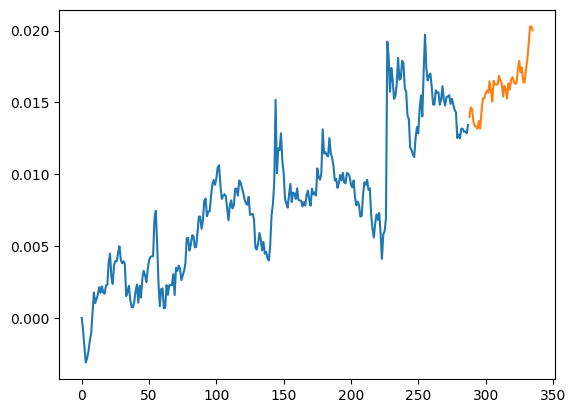

In [19]:
#plot random sample
rand_idx = np.random.randint(0, len(x))
plt.plot(np.arange(train_window_size), x[rand_idx,0,:].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), y_chunk[rand_idx,:].numpy())
print(y[rand_idx])

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(num_input_chans, 32, 5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, 5, padding=2)
        # self.conv4 = nn.Conv1d(128, 256, 9, padding=9)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(128)
        self.fc3 = nn.LazyLinear(64)
        self.fc4 = nn.LazyLinear(1)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(128)
        self.bn6 = nn.BatchNorm1d(64)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(F.max_pool1d(x, 2))
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.leaky_relu(F.max_pool1d(x, 2))
        x = self.bn2(x)
        x = self.conv3(x)
        x = F.leaky_relu(F.max_pool1d(x, 2))
        x = self.bn3(x)
        # x = self.conv4(x)
        # x = F.leaky_relu(F.max_pool1d(x, 2))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.bn4(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.bn5(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.bn6(x)
        x = self.fc4(x)
        return x
    
model = Model()
print(model(x).shape)    

torch.Size([128, 1])


c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(model, data, lr=.0001, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        for x, y, _ in data:
            x = x.to(device) # GPU
            y = y.to(device)
            opt.zero_grad()
            x_hat = model(x)
            loss = F.mse_loss(x_hat, y)
            loss.backward()
            opt.step()
            losses.append(loss.detach().cpu().numpy())
            print(f'epoch: {epoch}, loss: {loss}', end='\r')
        model.eval()
    return model, losses

model = model.to(device) # GPU
model, losses = train(model, train_dl, lr=0.002, epochs=1)

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].max() - 1


In [25]:
# x = np.arange(0, len(test_losses), 1/len(losses))
# # plt.plot(x, [np.log(loss.cpu().numpy()) for loss in losses])
# plt.plot([np.log(loss.cpu().detach().numpy()) for loss in test_losses])
plt.plot([loss.cpu().detach().numpy() for loss in losses])

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [24]:
# forawrd pass through test set while retraining
def train(model, data, lr=.0001, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        predictions = []
        model.train()
        for x, y, _ in data:
            x = x.to(device) # GPU
            y = y.to(device)
            opt.zero_grad()
            x_hat = model(x)
            predictions.append(x_hat.detach().cpu().numpy())
            loss = F.mse_loss(x_hat, y)
            loss.backward()
            opt.step()
            losses.append(loss.detach().cpu().numpy())
            print(f'epoch: {epoch}, loss: {loss}', end='\r')
    return model, losses, predictions

model = model.to(device) # GPU
model, losses, predictions = train(model, test_dl, lr=0.002, epochs=1)

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


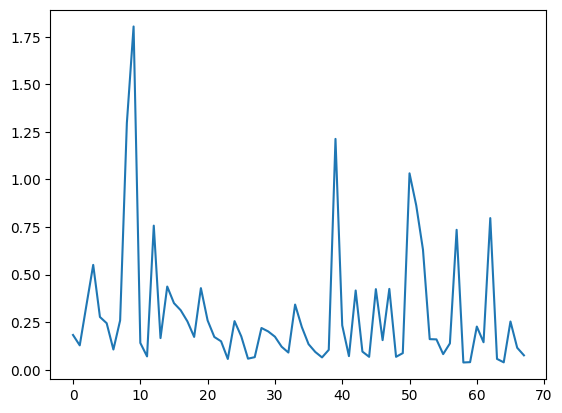

In [26]:
plt.plot(losses)

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


[-0.13924366]
tensor([-1.0710], device='cuda:0')


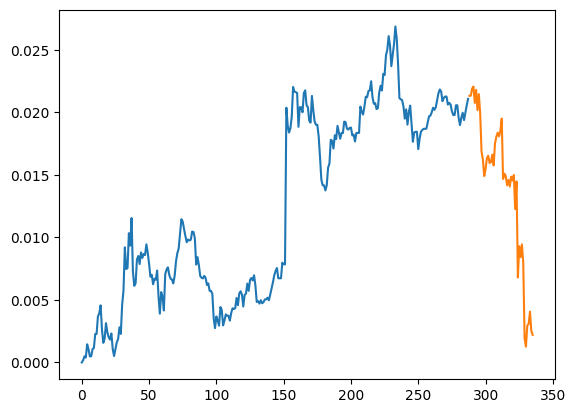

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


[-0.04411582]
tensor([0.0447], device='cuda:0')


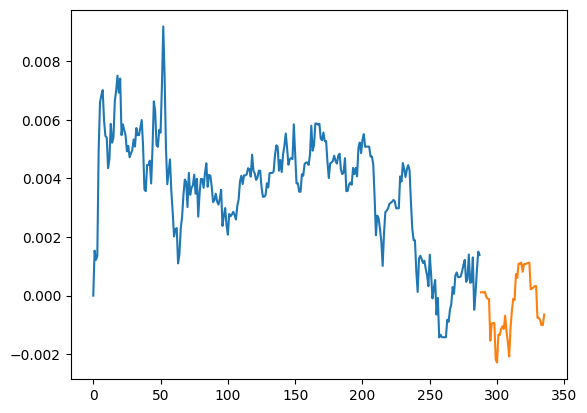

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


[-0.01230044]
tensor([-0.1696], device='cuda:0')


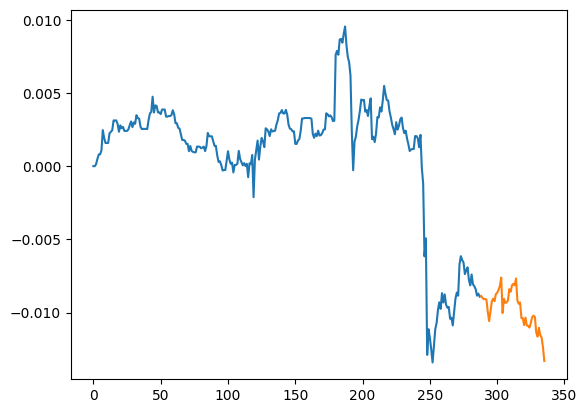

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


[-0.27221808]
tensor([-0.5079], device='cuda:0')


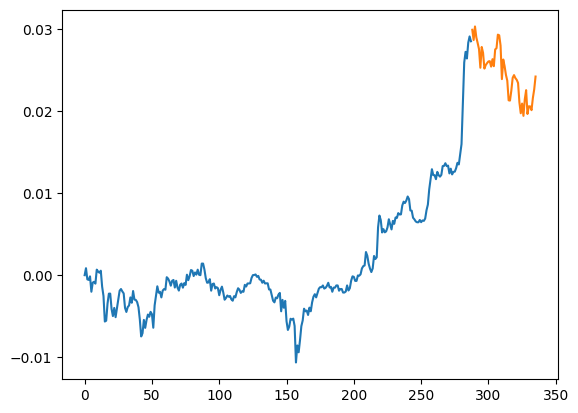

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


[0.06536607]
tensor([-0.9432], device='cuda:0')


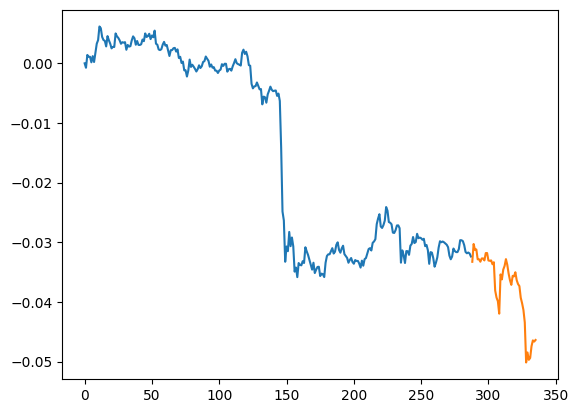

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


[0.0208338]
tensor([-0.7816], device='cuda:0')


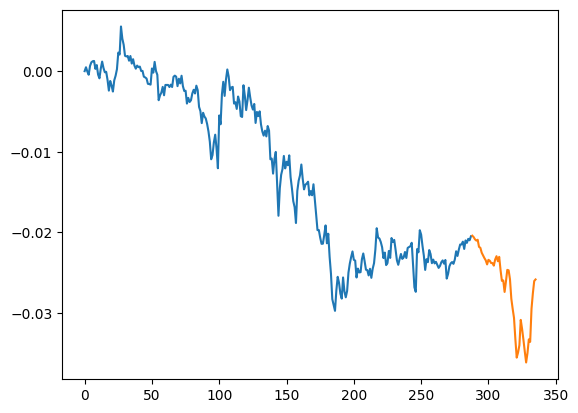

[0.5592005]
tensor([0.3439], device='cuda:0')


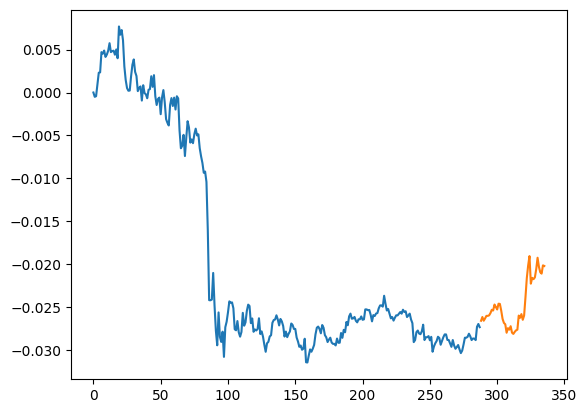

[-0.2770318]
tensor([0.2679], device='cuda:0')


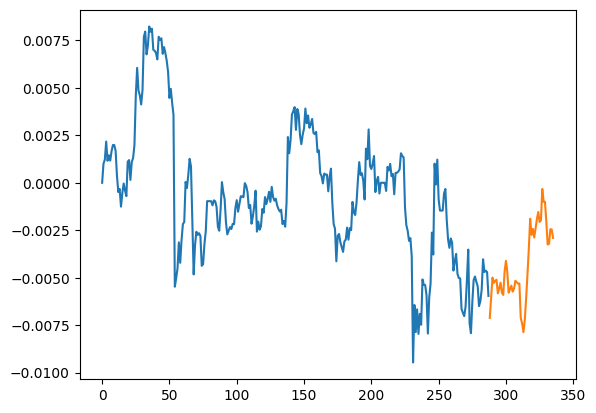

[0.07149013]
tensor([-0.0865], device='cuda:0')


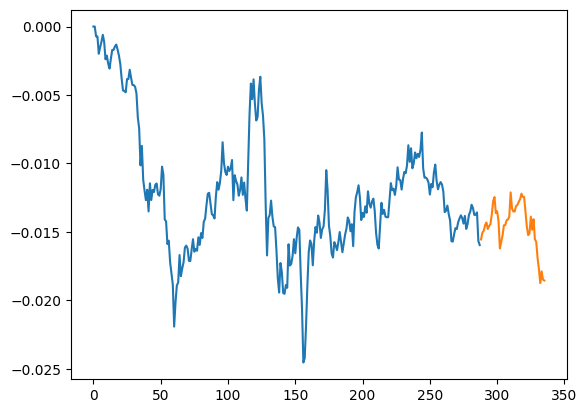

[-0.27654287]
tensor([0.7649], device='cuda:0')


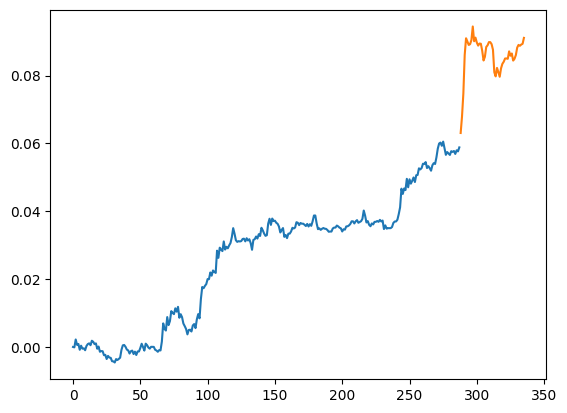

[-0.46708405]
tensor([-0.4830], device='cuda:0')


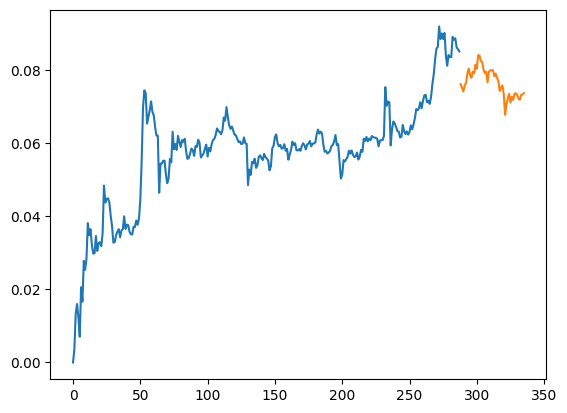

[-0.13311629]
tensor([-0.0986], device='cuda:0')


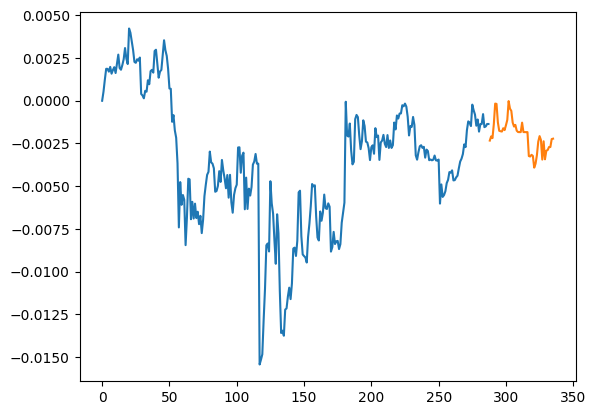

[-0.10567617]
tensor([1.2669], device='cuda:0')


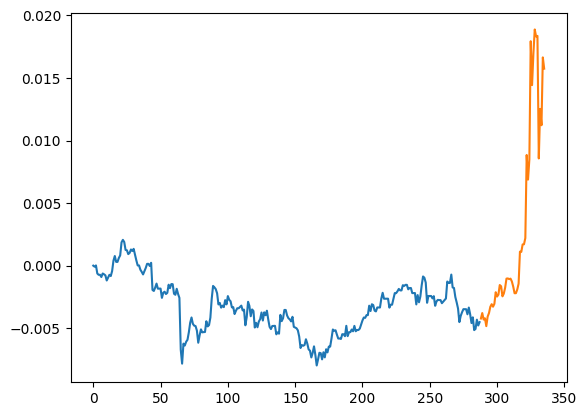

[0.38795927]
tensor([0.6308], device='cuda:0')


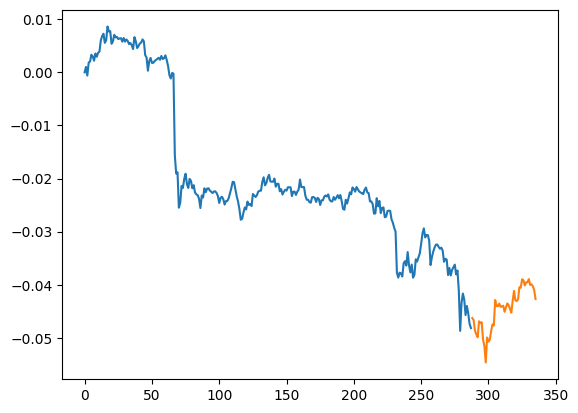

[-0.01582298]
tensor([0.3437], device='cuda:0')


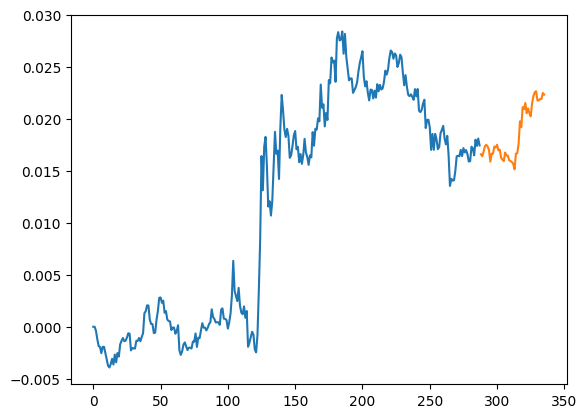

[-0.4120498]
tensor([-0.7074], device='cuda:0')


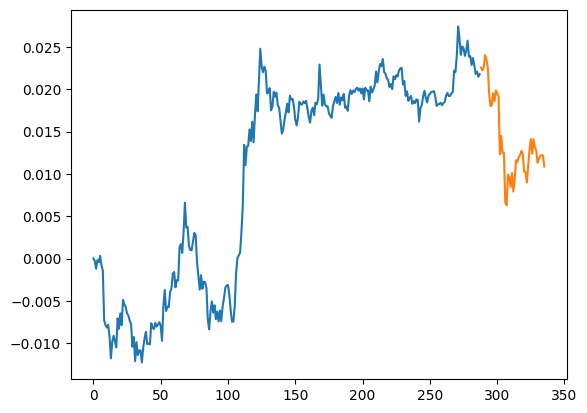

[-0.05534442]
tensor([0.0727], device='cuda:0')


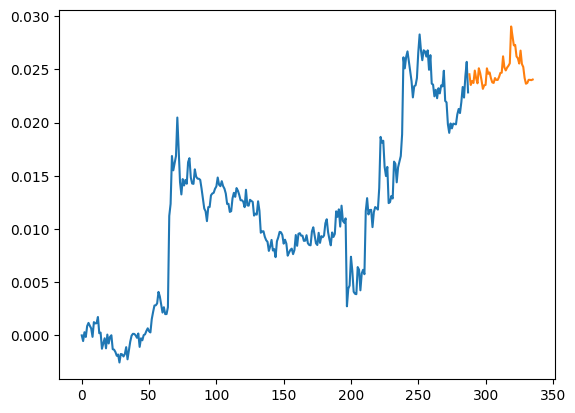

[-0.04745654]
tensor([0.2448], device='cuda:0')


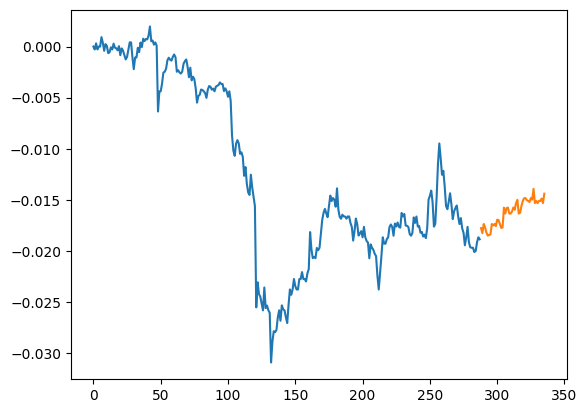

[-0.12559493]
tensor([0.0772], device='cuda:0')


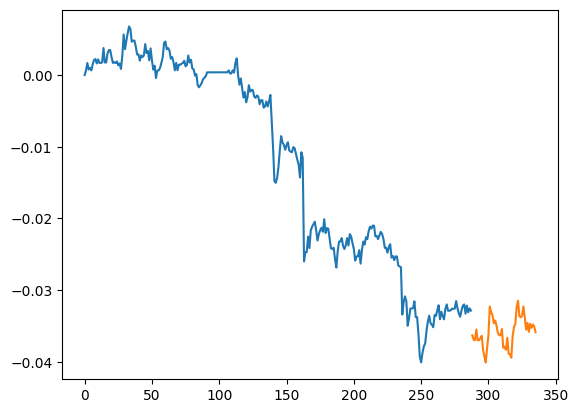

[-0.22346693]
tensor([-0.1393], device='cuda:0')


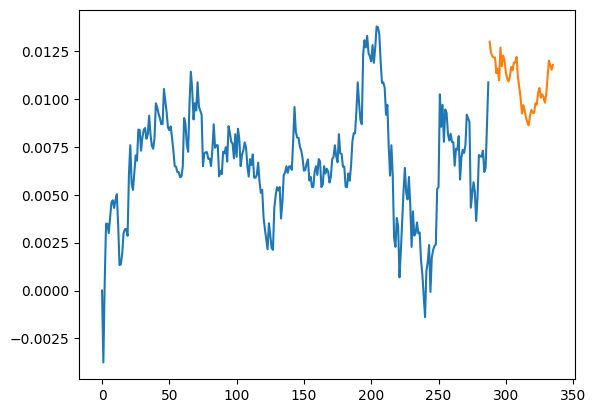

[-0.04873671]
tensor([0.0969], device='cuda:0')


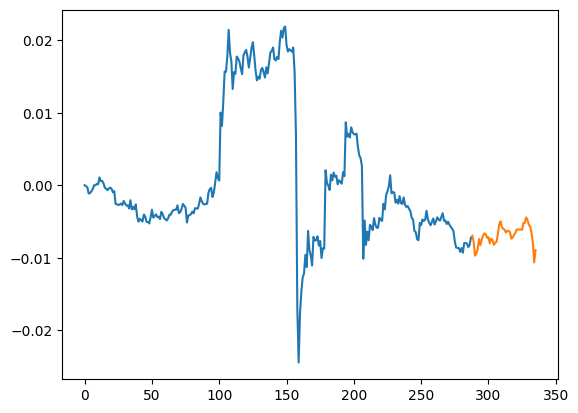

[0.08472581]
tensor([-0.1162], device='cuda:0')


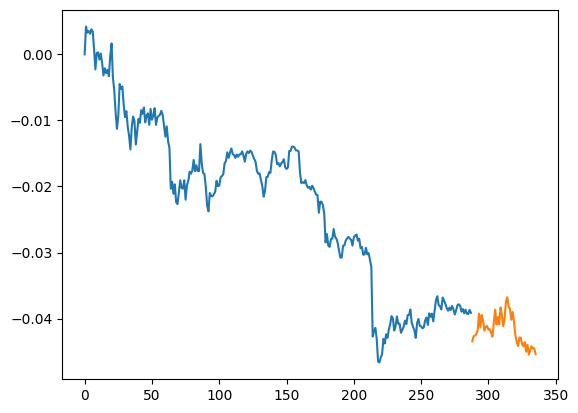

[0.04293837]
tensor([-0.0506], device='cuda:0')


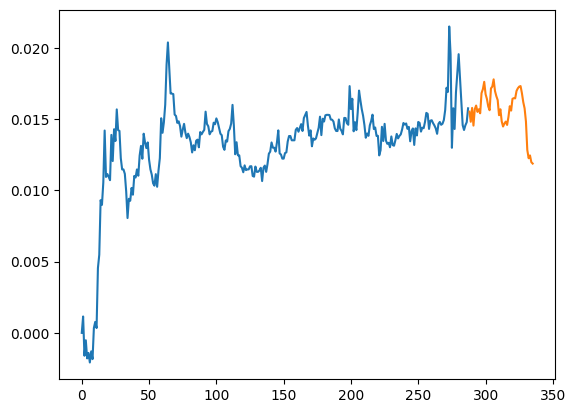

[0.265923]
tensor([0.6214], device='cuda:0')


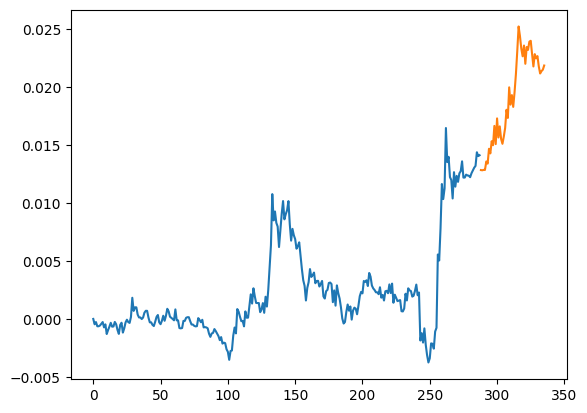

[-0.01605578]
tensor([-0.1342], device='cuda:0')


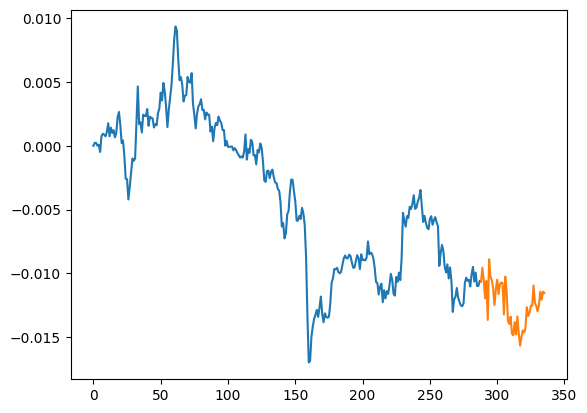

[0.21156923]
tensor([0.0175], device='cuda:0')


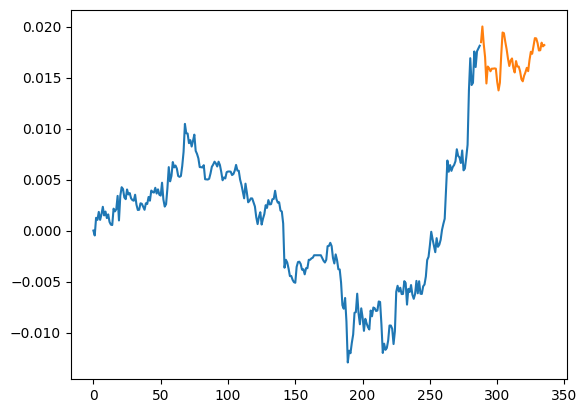

[-0.07414138]
tensor([0.1548], device='cuda:0')


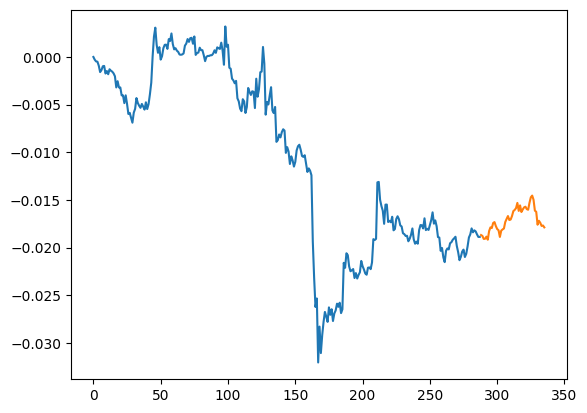

[-0.00036883]
tensor([0.1047], device='cuda:0')


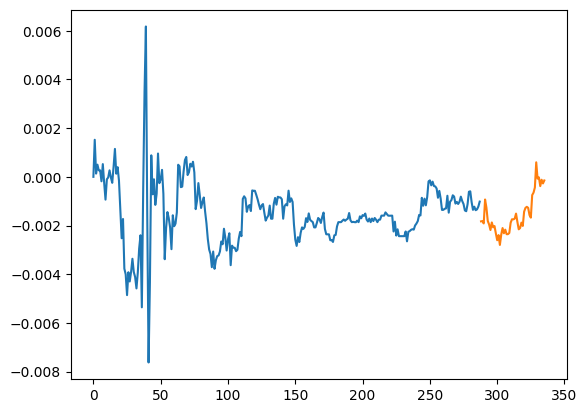

[0.03319737]
tensor([-0.2472], device='cuda:0')


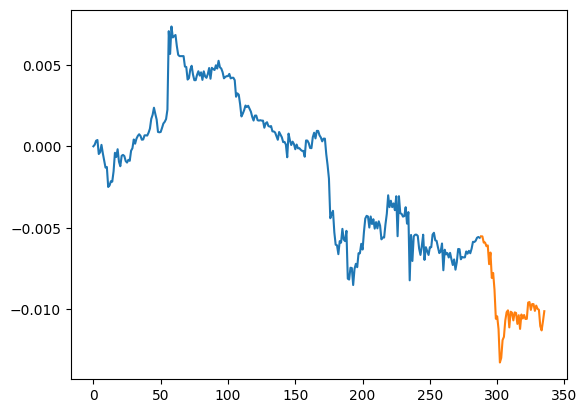

[0.03773714]
tensor([-0.2669], device='cuda:0')


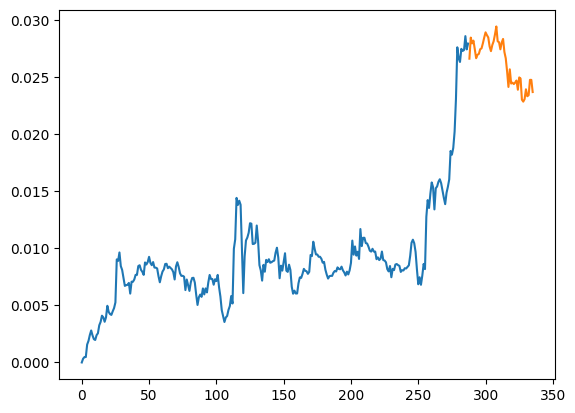

[-0.14587165]
tensor([-1.2384], device='cuda:0')


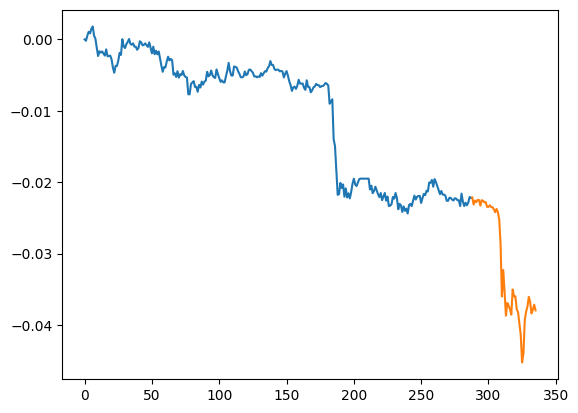

[-0.12599576]
tensor([0.0020], device='cuda:0')


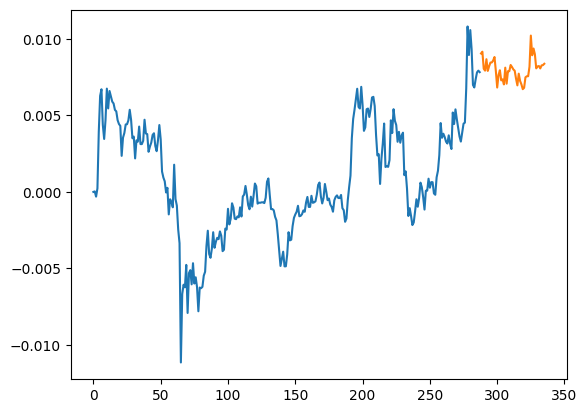

[-0.1379202]
tensor([-0.0907], device='cuda:0')


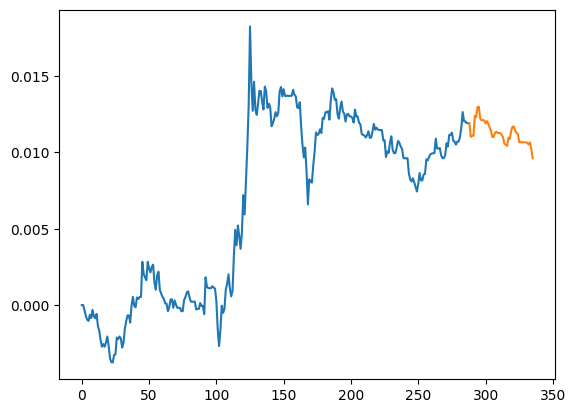

[-0.00712571]
tensor([0.2198], device='cuda:0')


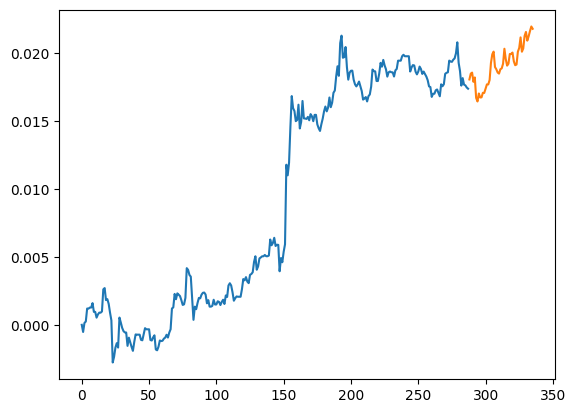

[0.19458014]
tensor([0.1662], device='cuda:0')


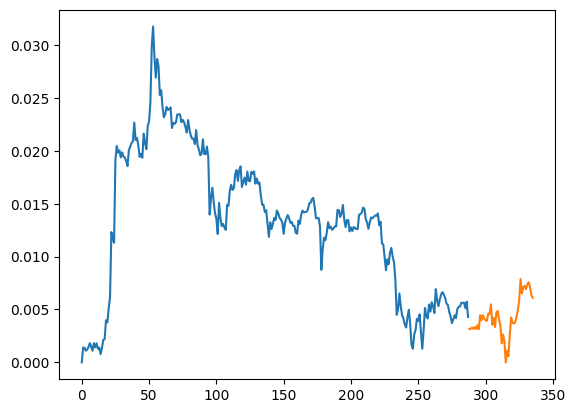

[-0.0053556]
tensor([-1.1222], device='cuda:0')


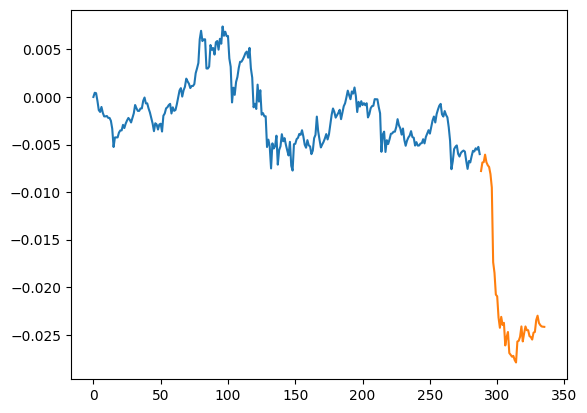

[-0.01126212]
tensor([0.0071], device='cuda:0')


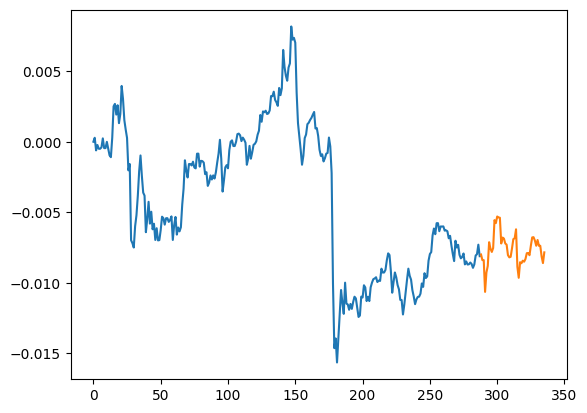

[-0.23746476]
tensor([0.0958], device='cuda:0')


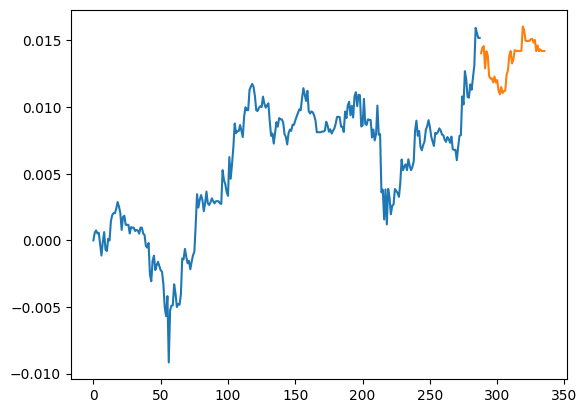

[-0.09627762]
tensor([0.2244], device='cuda:0')


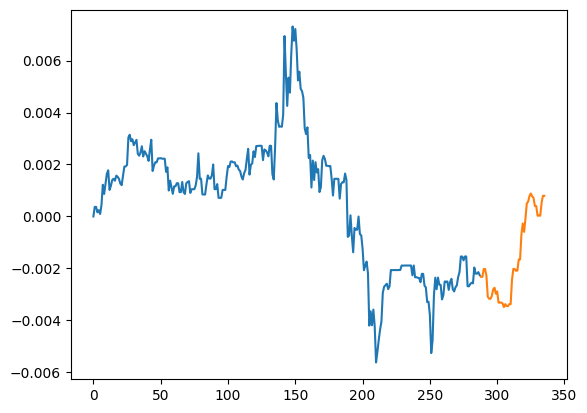

[-0.0428665]
tensor([-0.7695], device='cuda:0')


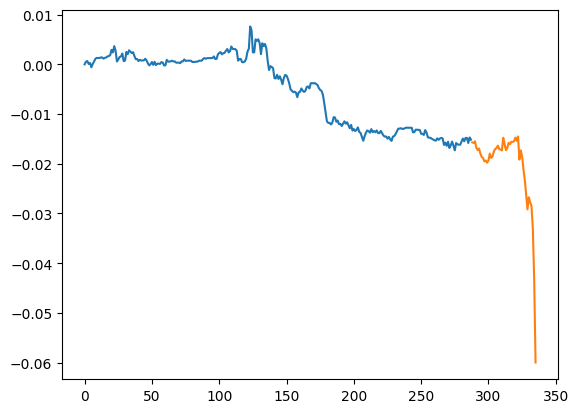

[0.02685328]
tensor([0.4455], device='cuda:0')


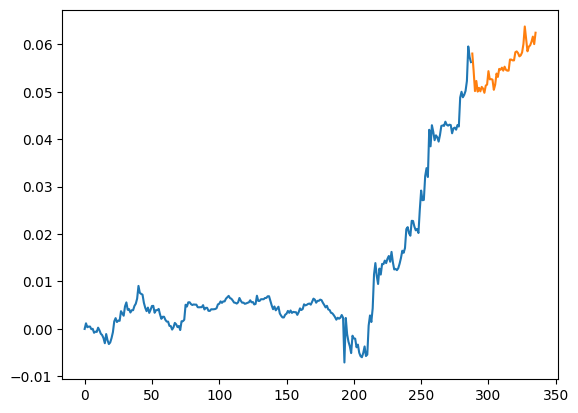

[-0.17289641]
tensor([0.1657], device='cuda:0')


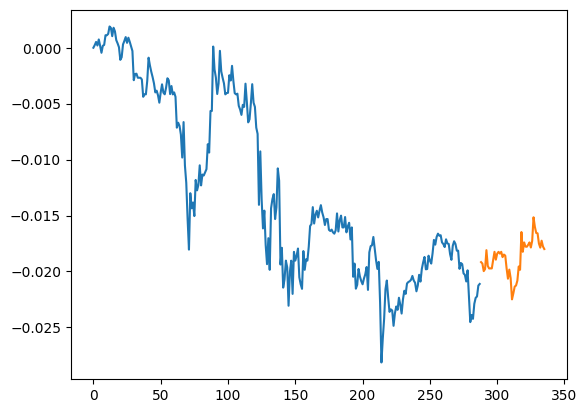

[-0.25277114]
tensor([-0.2525], device='cuda:0')


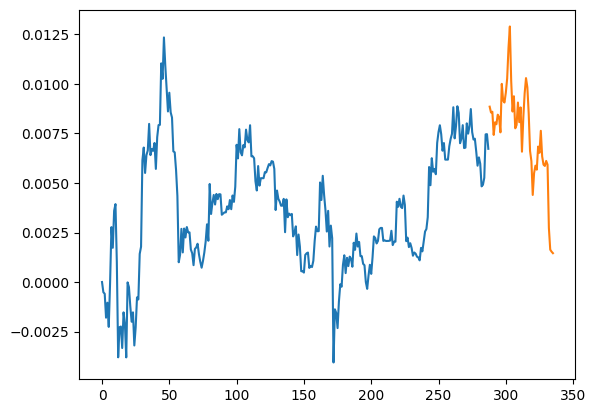

[-0.09305295]
tensor([0.3286], device='cuda:0')


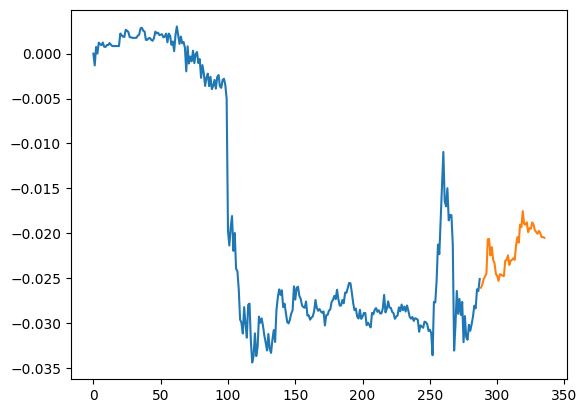

[-0.13214451]
tensor([0.0877], device='cuda:0')


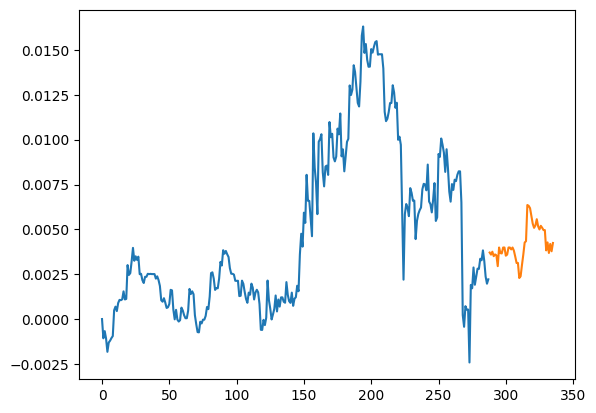

[-0.37805885]
tensor([-0.9232], device='cuda:0')


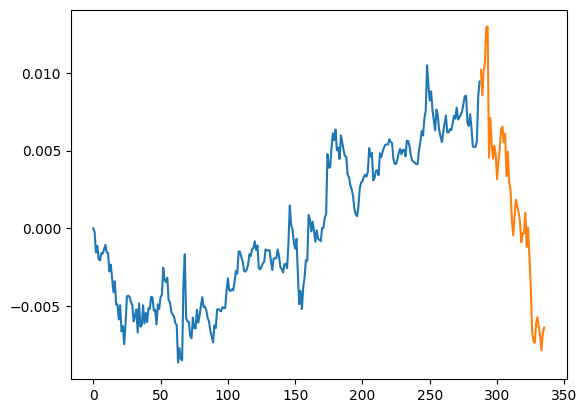

[-0.08785481]
tensor([-1.1628], device='cuda:0')


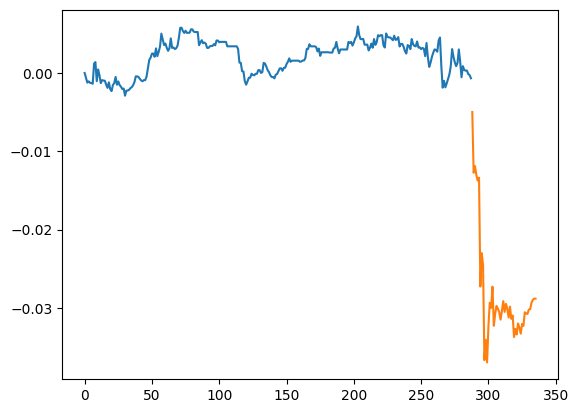

[0.10015658]
tensor([0.0475], device='cuda:0')


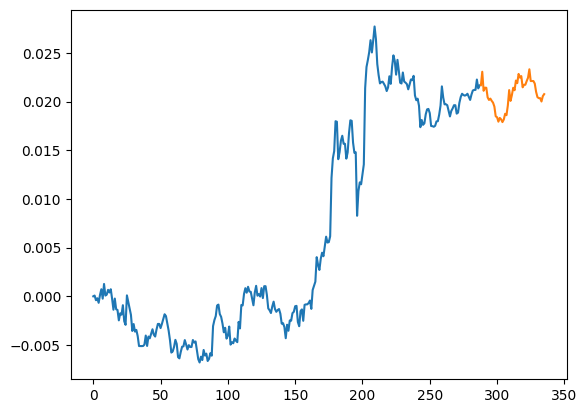

[-0.4269792]
tensor([-0.1831], device='cuda:0')


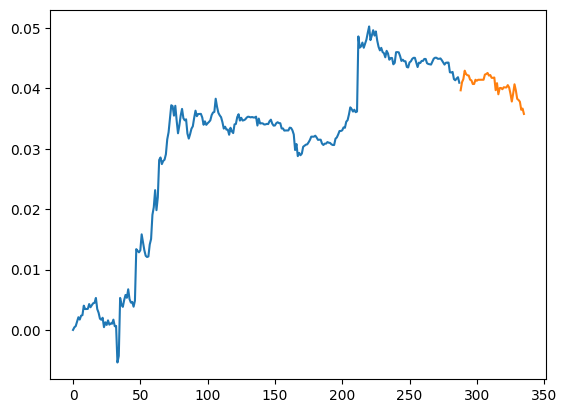

[-0.2974807]
tensor([-0.4436], device='cuda:0')


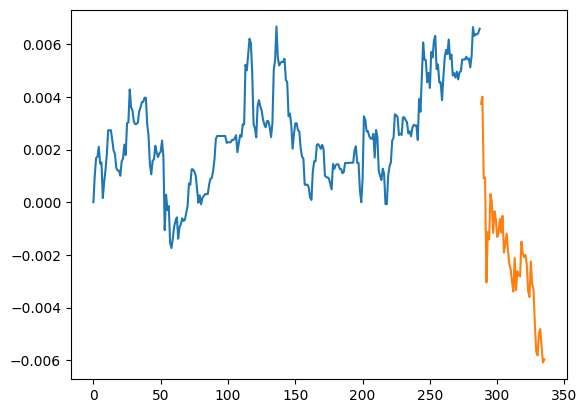

[-0.0885314]
tensor([-0.3363], device='cuda:0')


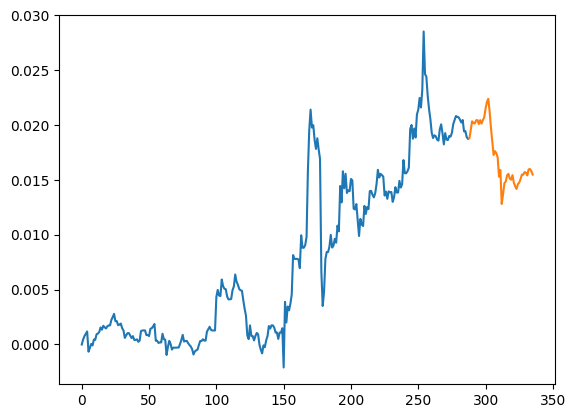

[-0.16182989]
tensor([2.1254], device='cuda:0')


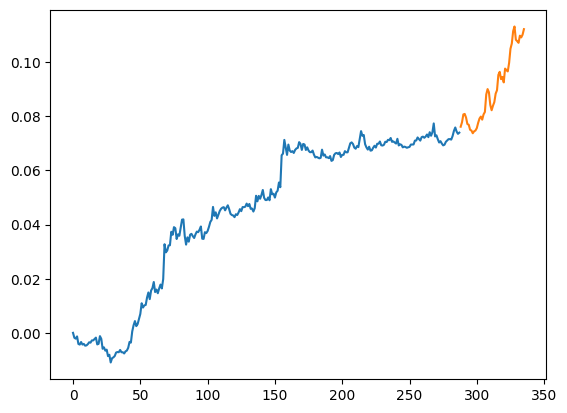

[0.0339421]
tensor([-0.5379], device='cuda:0')


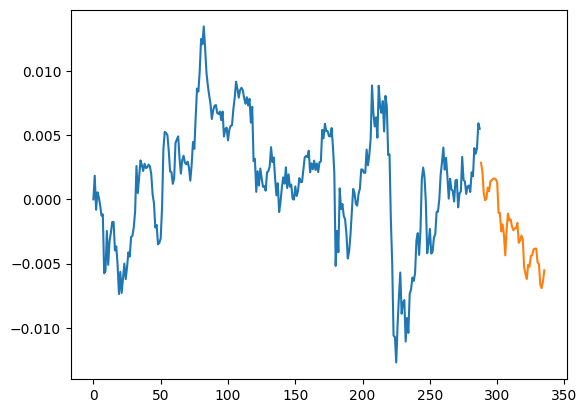

[-0.36368784]
tensor([-0.1896], device='cuda:0')


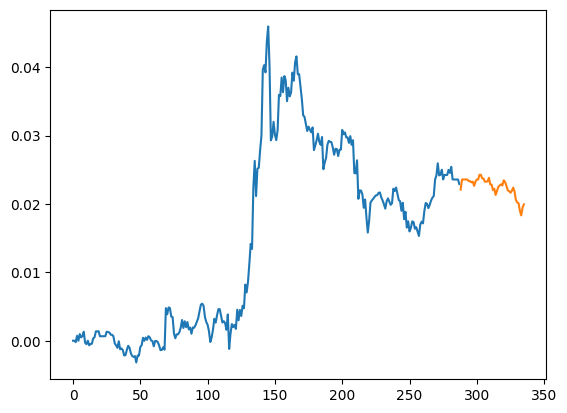

[-0.34916675]
tensor([-0.1707], device='cuda:0')


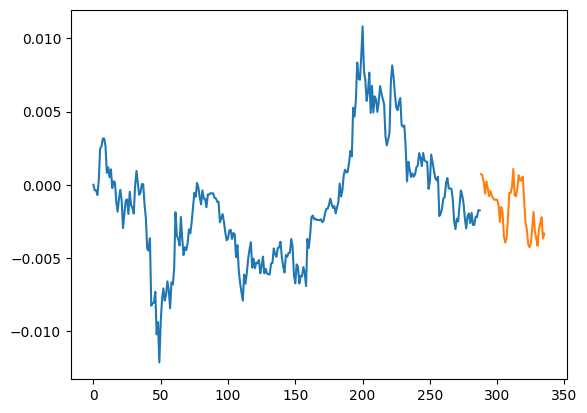

[0.07169034]
tensor([0.0214], device='cuda:0')


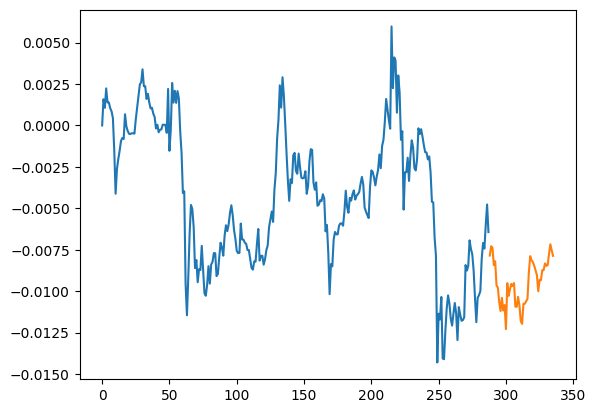

[-0.4302379]
tensor([-0.3631], device='cuda:0')


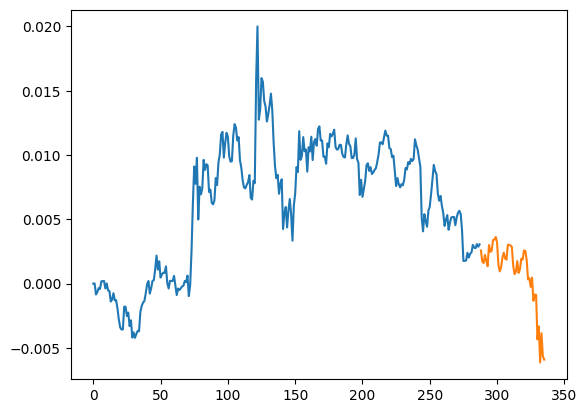

[0.32777157]
tensor([-0.4209], device='cuda:0')


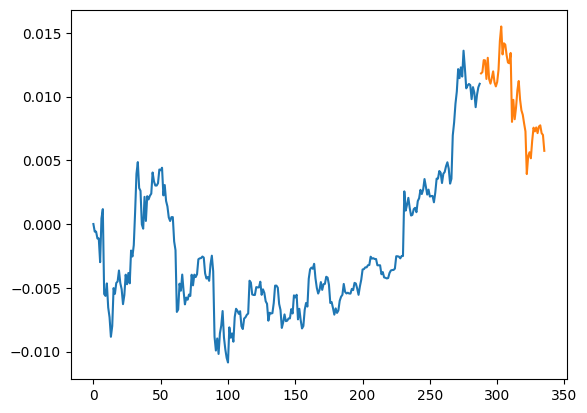

[-0.1222597]
tensor([0.2309], device='cuda:0')


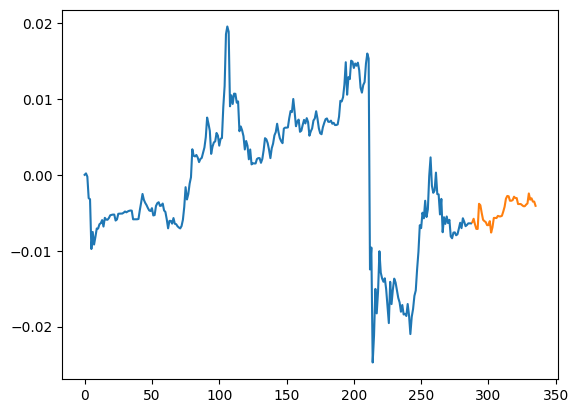

[0.04365553]
tensor([-0.0218], device='cuda:0')


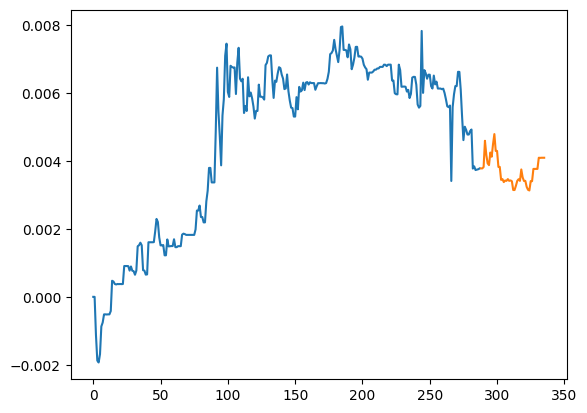

[-0.07319064]
tensor([0.8375], device='cuda:0')


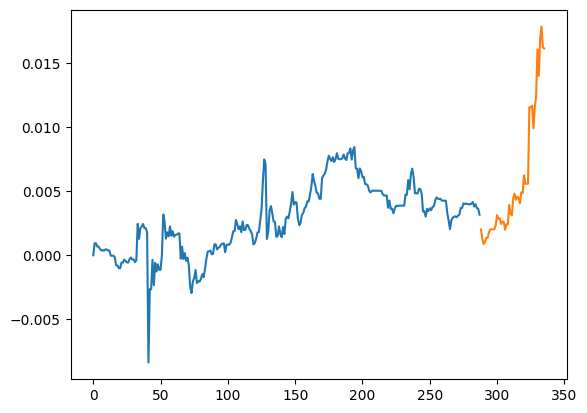

[0.09523545]
tensor([0.1333], device='cuda:0')


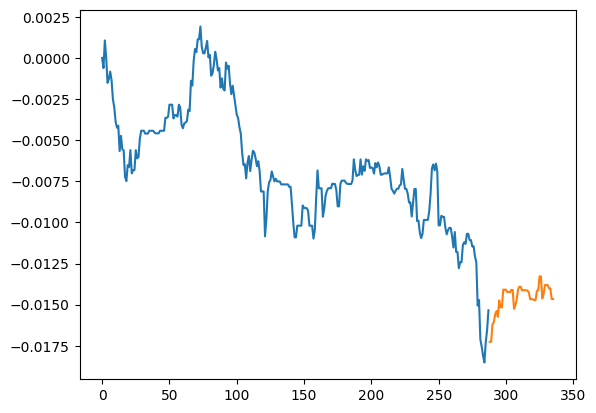

[-0.05845063]
tensor([0.7981], device='cuda:0')


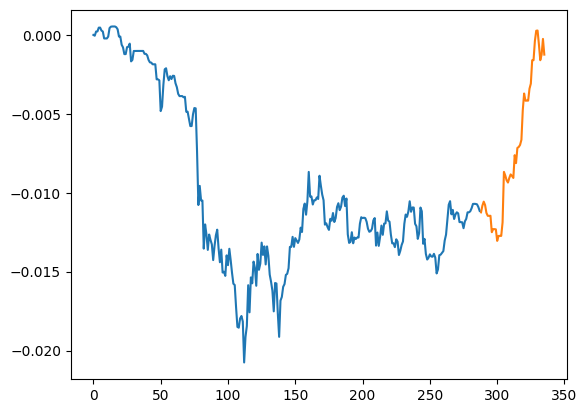

[-0.05096503]
tensor([0.5757], device='cuda:0')


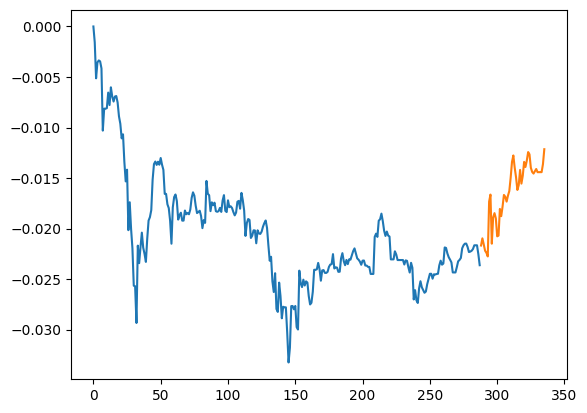

[0.16821787]
tensor([0.3231], device='cuda:0')


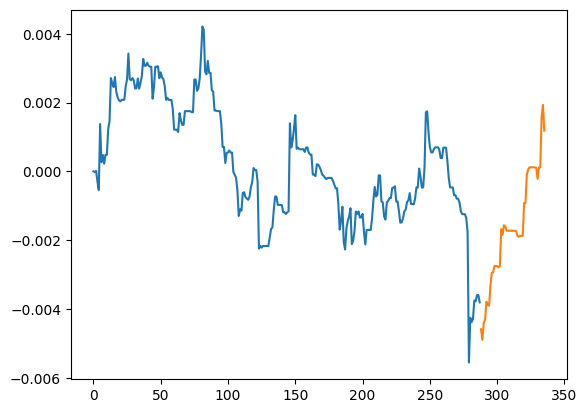

[0.16757339]
tensor([-0.0889], device='cuda:0')


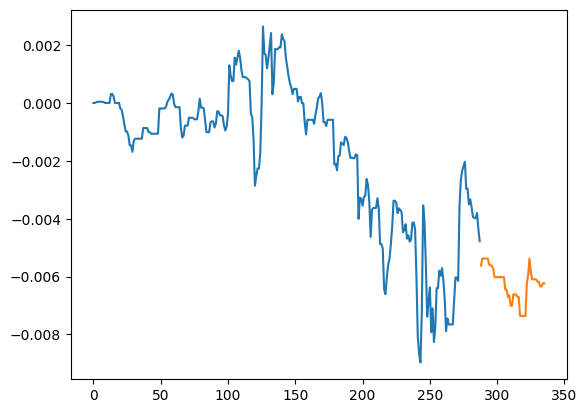

[-0.02222002]
tensor([0.4828], device='cuda:0')


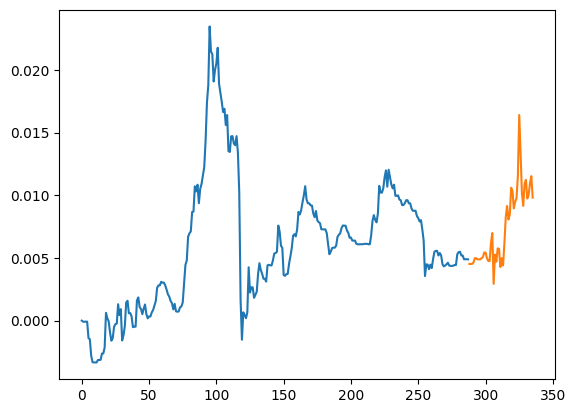

[0.05105936]
tensor([0.1919], device='cuda:0')


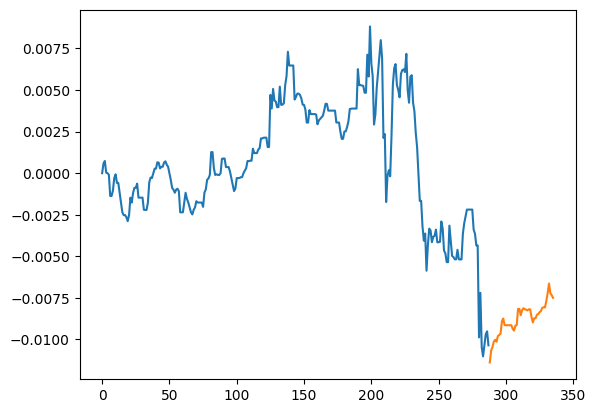

In [40]:
#show some predictions
model.eval()
for i, (x, y, y_chunk) in enumerate(test_dl):
    x = x.to(device) # GPU
    y = y.to(device)
    pred = predictions[i]
    plt.plot(np.arange(train_window_size), x[0,0,:].cpu().numpy())
    plt.plot(np.arange(train_window_size, train_window_size+target_window_size), y_chunk[0,:].cpu().numpy())
    print(pred[0])
    print(y[0])
    plt.show()


In [9]:
#save checkpoint 
save_path = r'C:/Users/avido\Documents/other code/AlgoTrading/Modeling/checkpoints/cnn1d_10_epochs.pt'
torch.save(model.state_dict(), save_path)

In [23]:
#show correlation between predicted and actual values
model.eval()
preds = []
actuals = []
for x, y, _ in test_dl:
    x = x.to(device)
    y = y.to(device)
    x_hat = model(x)
    preds.append(x_hat.detach())
    actuals.append(y)
preds = torch.cat(preds)
actuals = torch.cat(actuals)
plt.scatter(preds.cpu().detach().numpy(), actuals.cpu().detach().numpy(), alpha=.1)

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\4213154826.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


KeyboardInterrupt: 

C:\Users\avido\AppData\Local\Temp\ipykernel_36344\771290533.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1
C:\Users\avido\AppData\Local\Temp\ipykernel_36344\771290533.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].max() - 1


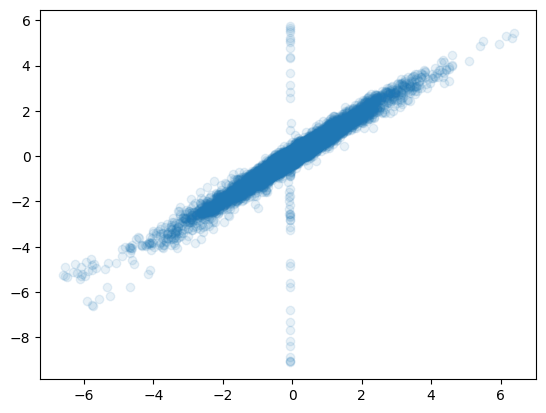

In [16]:
#show correlation between predicted and actual values on training data
model.eval()
preds = []
actuals = []
for x, y, _ in train_dl:
    x = x.to(device)
    x_hat = model(x)
    preds.append(x_hat.detach())
    actuals.append(y)
preds = torch.cat(preds)
actuals = torch.cat(actuals)
plt.scatter(preds.cpu().detach().numpy(), actuals.cpu().detach().numpy(), alpha=.1)

C:\Users\avido\AppData\Local\Temp\ipykernel_29480\3368812162.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[key] = chunk[key] / chunk[key].iloc[0] - 1


tensor([0.5260])
[[2.007488]]


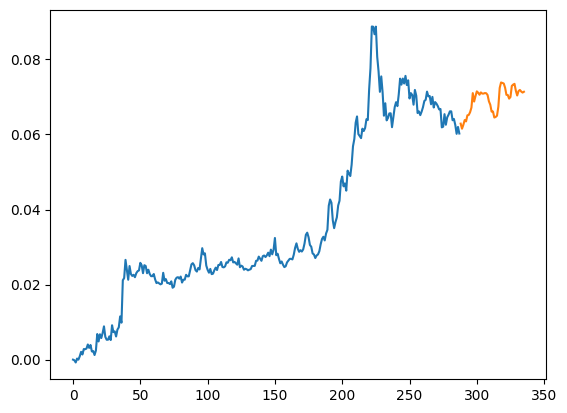

In [74]:
#plot an example
x, y, y_chunk = next(iter(test_dl))
rand_idx = np.random.randint(0, len(x))
plt.plot(np.arange(train_window_size), x[rand_idx,0,:].numpy())
plt.plot(np.arange(train_window_size, train_window_size+target_window_size), y_chunk[rand_idx,:].numpy())
print(y[rand_idx])
print(model(x[rand_idx].unsqueeze(0).to(device)).cpu().detach().numpy())
